In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import random

def sample_with_proportion(total, targets, proportion):
    total_sample = 10
    num_special = int(total_sample * proportion)
    special = np.random.choice(targets, num_special, replace=False)

    remaining = list(set(total) - set(targets))
    normal = np.random.choice(remaining, total_sample - num_special, replace=False)

    final = np.concatenate([special, normal])
    np.random.shuffle(final)
    return final

In [4]:
# datasets = range(1, 4) # DS3
# run_simulations(datasets,
#             sergio=True,
#             saucie=True, 
#             scScope=True, 
#             deepImpute=True, 
#             magic=True, 
#             genie=False,
#             arboreto=False,
#             pearson=False,
#             roc=False,
#             precision_recall_k=False
#         )

In [5]:
imp_dir = os.path.join(os.getcwd(), 'imputations')
print(imp_dir)
for i in range(1, 4):
    load_dir = os.path.join(imp_dir, f'DS{i}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    print(expr.shape)
    file_name = 'expr_shape.csv'
    if not os.path.exists(os.path.join(load_dir, file_name)):
        npfile = np.load(os.path.join(load_dir, save_name))
        shap = npfile.shape
        print(shap)
        df = pd.DataFrame([shap])
        df.to_csv(load_dir + '/' + file_name, index=False)

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations
(9, 100, 300)
(9, 100, 300)
(9, 400, 300)
(9, 400, 300)
(9, 1200, 300)
(9, 1200, 300)


In [6]:
imp_dir = os.path.join(os.getcwd(), 'imputations')

def run_pearson_ranking(proportion):
    print("Running Pearson ranking tests with proportion", proportion)
    for i in range(1, 4):
        gt_file = None
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        # For now, just load clean data, save as csv, and load it back in
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        file_name = ''
        save_name = ''
        for method in methods:
            if method == 'Clean':
                file_name = f'DS6_clean.npy'
                save_name = f'DS6_clean.csv'
            elif method == 'Noisy':
                file_name = f'DS6_45.npy'
                save_name = f'DS6_45.csv'
            elif method == 'SAUCIE':
                file_name = f'yhat_SAUCIE.npy'
                save_name = f'yhat_SAUCIE.csv'
            elif method == 'scScope':
                file_name = f'yhat_scScope.npy'
                save_name = f'yhat_scScope.csv'
            elif method == 'DeepImpute':
                file_name = f'yhat_deepImpute.npy'
                save_name = f'yhat_deepImpute.csv'
            elif method == 'MAGIC':
                file_name = f'yhat_MAGIC_t_auto.npy'
                save_name = f'yhat_MAGIC_t_auto.csv'
            load_dir = os.path.join(imp_dir, f'DS{i}')
            if not os.path.exists(os.path.join(imp_dir, f'DS{i}', save_name)):
                npfile = np.load(load_dir + '/' + file_name)
                df = pd.DataFrame(npfile)
                df.to_csv(load_dir + '/' + save_name, index=False)
            clean_df = pd.read_csv(os.path.join(load_dir, save_name))
            
            # Read ground truth
            gt = pd.read_csv(gt_file, header=None)
            confirmed_genes = gt[0].unique()

            # Run Pearson on clean and noisy data
            pearson = Pearson(np.transpose(clean_df), '')
            p_values = pearson.values
            np.fill_diagonal(p_values, 0)
            pearson = pd.DataFrame(p_values, index=pearson.columns, columns=pearson.columns)

            total = 0
            for r in range(50):
                sampled = sample_with_proportion(clean_df.index.tolist(), confirmed_genes, proportion)
            # Take subset of pearson data with only the sampled genes
                p_subset = pearson.loc[sampled]
            #print(p_subset)
            # Rank the expression pairs by the absolute value of the pearson correlation
                melted = pd.melt(p_subset.reset_index(), id_vars=['index'], value_vars=p_subset.columns)
                melted.columns = ['input', 'target', 'correlation']
                melted_sorted = melted.sort_values(by='correlation', ascending=False)
                ranked_list = list(melted_sorted.itertuples(index=False, name=None))[:10]
            # Calculate the proportion of confirmed genes in the top k of the ranked pairs
                top_10 = [(input, target) for input, target, _ in ranked_list]
                true_pairs = set(tuple(x) for x in gt.values)
                matches = sum(1 for pair in top_10 if pair in true_pairs)
                prop = matches / len(top_10)
                total += prop

            print(f"DS{i}", method, total / 50)

In [7]:
# run_pearson_ranking(0.1)
# run_pearson_ranking(0.2)
# run_pearson_ranking(0.3)

In [8]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import random

def run_pearson_edge_sampling(proportion):
    print("Running Pearson edge sampling tests with proportion", proportion)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    
    for i in range(1, 4):
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        
        for method in methods:
            file_name = f'DS{i}_{method}.csv'  # Adjusted for simplicity
            load_dir = os.path.join(imp_dir, f'DS{i}')
            data_file_path = os.path.join(load_dir, file_name)

            if not os.path.exists(data_file_path):
                print(f"File {data_file_path} does not exist. Skipping.")
                continue
            
            clean_df = pd.read_csv(data_file_path)
            gt = pd.read_csv(gt_file, header=None)
            
            confirmed_edges = set(tuple(x) for x in gt.values)
            
            all_possible_edges = [(row, col) for row in clean_df.columns for col in clean_df.columns if row != col]
            num_edges_to_sample = int(len(all_possible_edges) * proportion)
            
            total = 0
            for r in range(50):
                sampled_edges = random.sample(all_possible_edges, num_edges_to_sample)
                matches = 0
                for edge in sampled_edges:
                    gene1, gene2 = edge
                    corr, _ = pearsonr(clean_df[gene1], clean_df[gene2])
                    # Check if this edge is in the confirmed edges and if the correlation is significant
                    if edge in confirmed_edges and abs(corr) > 0.5:  # Threshold for "significant" correlation can be adjusted
                        matches += 1
                prop = matches / len(sampled_edges)
                total += prop
            
            print(f"DS{i} {method}: Proportion of significant confirmed edges = {total / 50}")

# Example usage
proportion = 0.1
run_pearson_edge_sampling(proportion)


Running Pearson edge sampling tests with proportion 0.1
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Noisy.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_SAUCIE.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_scScope.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_DeepImpute.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_MAGIC.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/DS2_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/

In [11]:
from parallel_utils import process_iteration
from time import time
import concurrent
from concurrent.futures import ProcessPoolExecutor

def edge_finding_experiment(dataset_id, last_iteration=0, fixed_edge=False):
    print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    correlations = []

    # check if experiment file exists for this dataset
    experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment.csv")
    if fixed_edge:
        experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment_fixed_edge.csv")
    if os.path.exists(experiment_file) and last_iteration != 0:
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        correlations = df['Correlation'].values.tolist()  
    
    fixed_chosen_pair = None
    
    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in tqdm(range(last_iteration, 51)):
            file_extension = ''
            if iteration == 0:
                #run_sergio(target_file, regs_path, i, file_extension)
                clean_df = pd.DataFrame(np.load(os.path.join(load_dir, f"DS6_clean{file_extension}.npy")))
                true_pearson = Pearson(np.transpose(clean_df), '')
                p_values = true_pearson.values
                np.fill_diagonal(p_values, 0)
                true_pearson = pd.DataFrame(p_values, index=true_pearson.columns, columns=true_pearson.columns)
            else:
                file_extension = f'_iter{iteration}'
                futures.append(executor.submit(process_iteration, iteration, target_file, regs_path, master_regs, load_dir, imp_dir, dataset_id, file_extension))
        iter = 0
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            pearson, chosen_pair, temp_target, f_ext = future.result()
            if fixed_edge and iter == 0:
                fixed_chosen_pair = chosen_pair
            elif fixed_edge:
                while fixed_chosen_pair is None:
                    time.sleep(0.1)
                chosen_pair = fixed_chosen_pair
            regulator_row = pearson.loc[chosen_pair[0]]
            true_regulator_row = true_pearson.loc[chosen_pair[0]]
            
            # Take difference between calculated and true values
            abs_diff = np.abs(true_regulator_row - regulator_row)
            sorted_row = abs_diff.sort_values(ascending=False)

            #print(abs_diff.index(chosen_pair[1]), sorted_row.index(chosen_pair[1]))
            rank_target = sorted_row.index.get_loc(chosen_pair[1])
            ranks.append(rank_target)
            rank_value = sorted_row.iloc[rank_target]
            correlations.append(rank_value)
            # add to experiment file
            df = pd.DataFrame({'Rank': ranks, 'Correlation': correlations})
            df.to_csv(experiment_file, index=False)
                    
            print(chosen_pair[0], chosen_pair[1], rank_target, rank_value)
            print("Current iteration:", iter, f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))
            # delete most temp files, keep every five
            if iter % 10 != 0:
                os.remove(temp_target)
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        print(f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))

In [ ]:
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=True)

In [ ]:
!pip install seaborn

Means for DS 1 Rank: 16.28 Correlation: 0.15013161087849597
Medians for DS 1 Rank: 5.0 Correlation: 0.1434946400612857
Means for DS 2 Rank: 72.86 Correlation: 0.14540740829884288
Medians for DS 2 Rank: 18.0 Correlation: 0.14470418553123043
Means for DS 3 Rank: 227.18 Correlation: 0.1394348314181487
Medians for DS 3 Rank: 50.0 Correlation: 0.1311190609682338


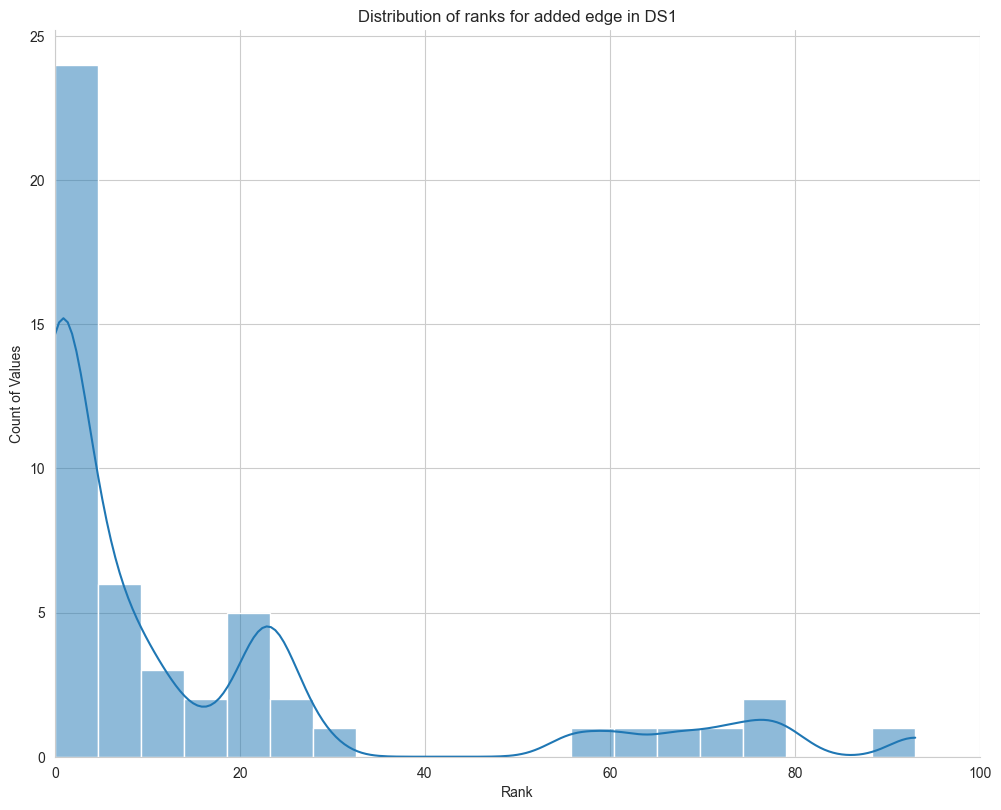

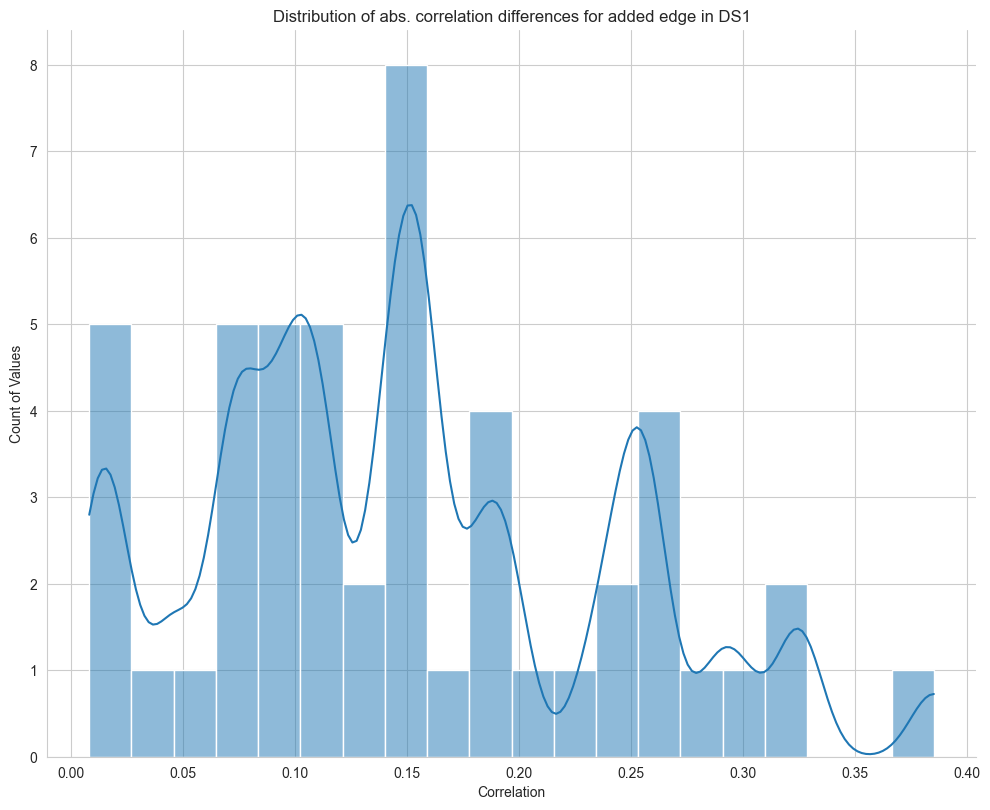

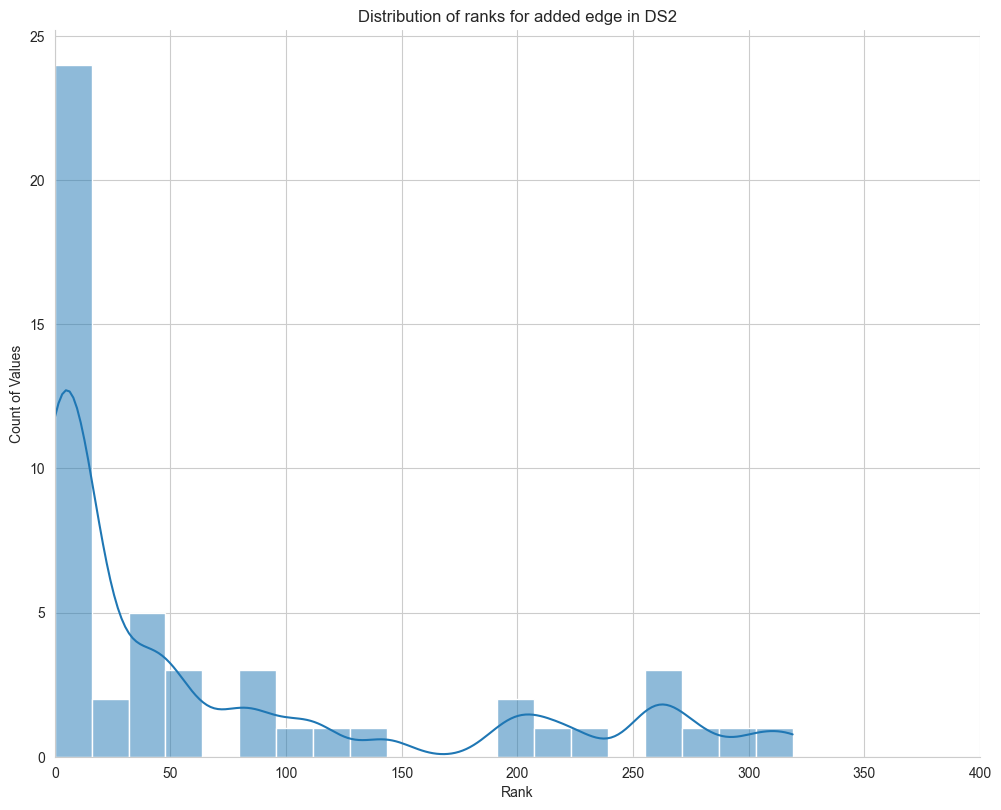

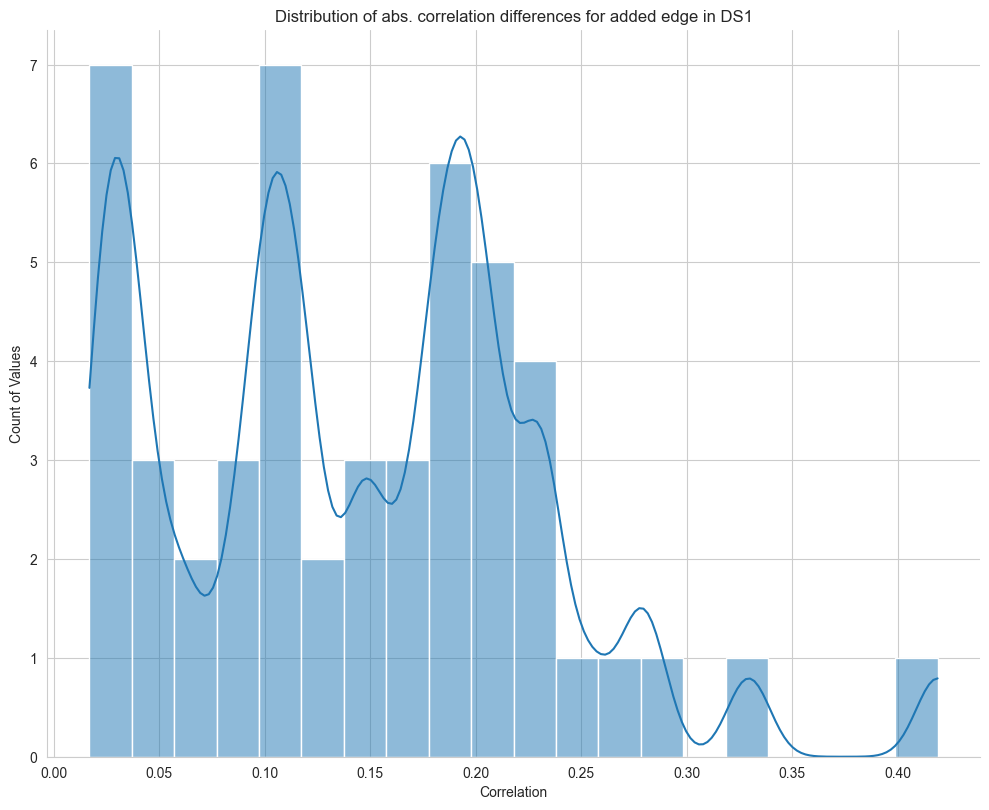

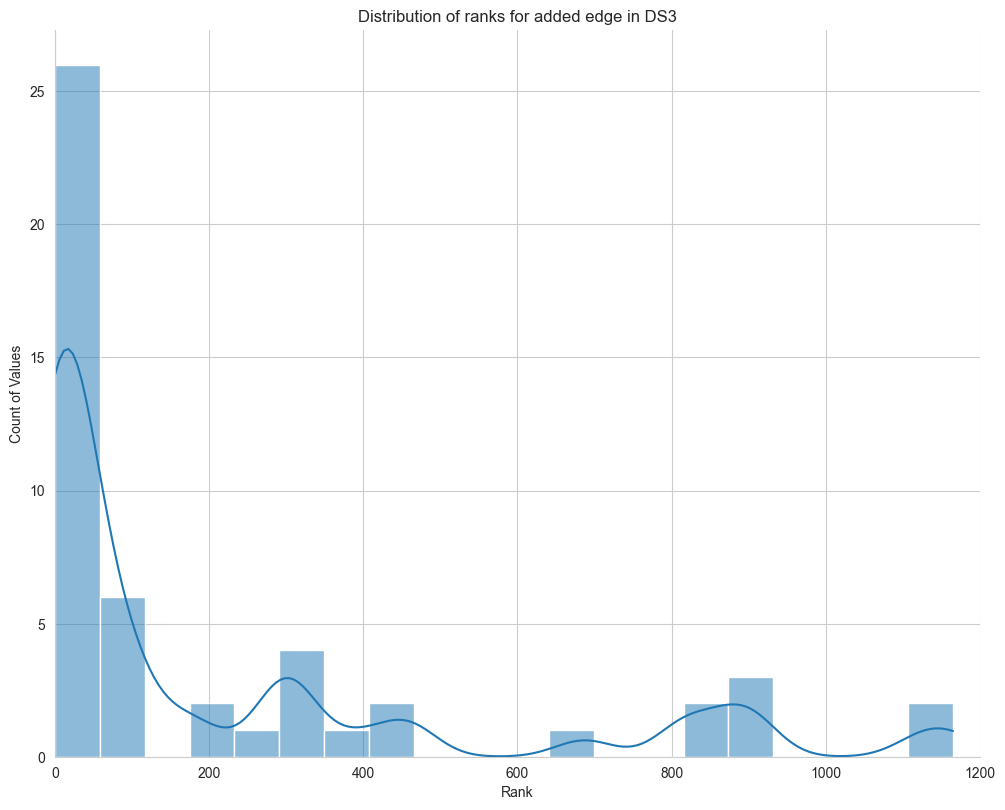

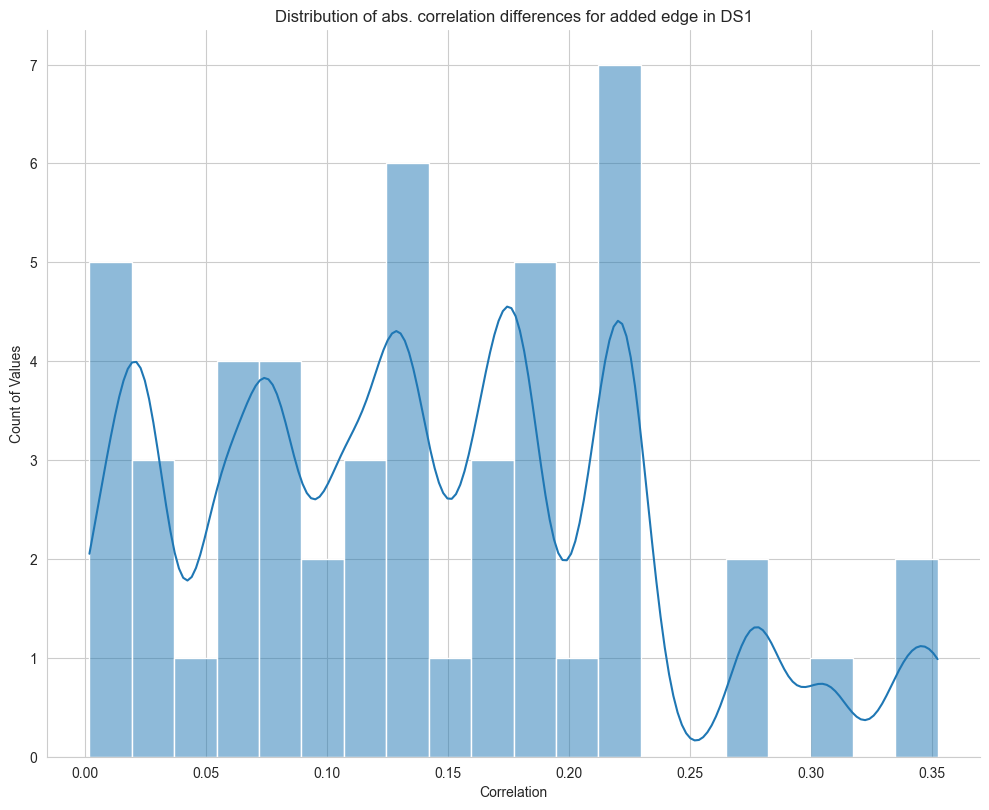

In [23]:
import seaborn as sns
## Plot the results from the experiment
dataset_id = 1
experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
for id in range(1, 4):
    experiment_file = os.path.join(experiment_dir, f"DS{id}_edge_finding_experiment.csv")

    load_dir = os.path.join(imp_dir, f'DS{id}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    lim = expr.shape[1]
    

    df = pd.read_csv(experiment_file)
    sns.set_style("whitegrid")
    # density plot
    plot = sns.displot(df['Rank'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    plot.set(xlim=(0, lim))
    plot.set_axis_labels('Rank', 'Count of Values')
    plt.title(f'Distribution of ranks for added edge in DS{id}')


    plot = sns.displot(df['Correlation'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    #plot.set(xlim=(0, 1))
    plot.set_axis_labels('Correlation', 'Count of Values')
    plt.title(f'Distribution of abs. correlation differences for added edge in DS{dataset_id}')

    print("Means for DS", id, "Rank:", np.mean(df['Rank']), "Correlation:", np.mean(df['Correlation']))
    print("Medians for DS", id, "Rank:", np.median(df['Rank']), "Correlation:", np.median(df['Correlation']))


In [107]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def polynomial_model(x_j, k, n, h):
    numerator = (x_j ** (n + 1))
    denominator = ((x_j ** n) + (h ** n))
    return k * (numerator / denominator)

def fit_poly(x_j, x_i, n, h):
    initial = [1]
    params, _ = curve_fit(lambda x_j, Kij: polynomial_model(x_j, Kij, n, h), x_j, x_i, p0=initial)
    #print(curve_fit(lambda x_j, Kij: polynomial_model(x_j, Kij, n, h), x_j, x_i, p0=initial))
    k_est = params[0]
    return k_est
    #fitted = polynomial_model(x_j, k_est, n, h)
    #error = np.mean(np.abs(fitted - x_i) ** 2)
    #return k_est, error

def calculate_polynomial(x_j, k, h, n):
    numerator = (x_j ** (n))
    denominator = ((x_j ** n) + (h ** n))
    hill = numerator / denominator
    if k < 0:
        return k * (1 - hill)
    else:
        return k * hill
    
def fit_gaussian(row):
    mean, std = norm.fit(row)
    return pd.Series({'mean': mean, 'std': std})

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

In [9]:
from consolidated_runs import run_sergio
from parallel_utils import new_mean_process_iteration
import random
from time import time
import concurrent
from concurrent.futures import ProcessPoolExecutor

def new_expected_value_experiment(dataset_id, last_iteration=0, fixed_edge=False, add_edge=True, multiple_edges=False, clean='clean', normalize=False):
    #print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
        n_genes = 100
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
        n_genes = 400
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        n_genes = 1200
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    means = []

    experiment_dir = os.path.join(os.getcwd(), f'experiments/mean_diffs/DS{dataset_id}')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_mean_diff_experiment.csv")
    if fixed_edge:
        experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_mean_diff_experiment_fixed_edge.csv")
    if os.path.exists(experiment_file) and last_iteration != 0:
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        means = df['Correlation'].values.tolist()

    run_sergio(target_file, regs_path, dataset_id, file_extension='')

    if normalize:
        clean_df = pd.DataFrame(np.load(os.path.join(load_dir, f"DS6_clean.npy")))
        total_counts = clean_df.sum(axis=0)
        normalized_df = clean_df.divide(total_counts, axis='columns') #* 1e6 # counts per million?
        np.save(os.path.join(load_dir, f"DS6_clean.npy"), normalized_df.to_numpy())

    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in range(last_iteration, 51):      
            file_extension = ''                          
            file_extension = f"_iter{iteration}"
            # Get number of genes to choose a target
            if iteration != 0:
                futures.append(executor.submit(new_mean_process_iteration, iteration, target_file, regs_path, master_regs, load_dir, add_edge, multiple_edges, imp_dir, dataset_id, file_extension, clean, normalize))
        
        iter = 0
        chosen_pairs = []
        chosen_pair_filename = os.path.join(experiment_dir, f"DS{dataset_id}_chosen_pairs.csv")
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            ranks, final_ranks, temp_target, f_ext, ds_iter = future.result()
            #print(chosen_pair, rank)
            experiment_file_ranks = experiment_file.replace('.csv', f'_iter{ds_iter}.csv')
            ranks.to_csv(experiment_file_ranks, index=False)
            #print(final_ranks)
            for tup in final_ranks:
                chosen_pair = (tup[0], tup[1])
                add = tup[2]
                rank = ranks.index.get_loc(chosen_pair[1]) + 1
                if not add:
                    rank = n_genes - rank
                # print(chosen_pair[0], chosen_pair[1], rank, add)
                target_val = tup[4]
                target_val = ranks.loc[chosen_pair[1]]['mean']
                overall_mean = np.mean(ranks['mean'])
                chosen_pairs.append([chosen_pair[0], chosen_pair[1], rank, target_val, overall_mean, add, ds_iter])
            if ds_iter % 10 != 0:
                #print(temp_target)
                os.remove(temp_target)
                os.remove(os.path.join(experiment_dir, f"DS{dataset_id}_mean_diff_experiment_iter{ds_iter}.csv"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        chosen_pair_df = pd.DataFrame(chosen_pairs)
        chosen_pair_df.to_csv(chosen_pair_filename, index=False)

In [10]:
new_expected_value_experiment(dataset_id=1, last_iteration=0, fixed_edge=False, add_edge=True, multiple_edges=False, clean='clean', normalize=True)
new_expected_value_experiment(dataset_id=2, last_iteration=0, fixed_edge=False, add_edge=True, multiple_edges=False, clean='clean', normalize=True)
new_expected_value_experiment(dataset_id=3, last_iteration=0, fixed_edge=False, add_edge=True, multiple_edges=False, clean='clean', normalize=True)

,0,1,2,3,4,5,6,7,8,9,...,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699
0,0.000981,0.000287,0.000397,0.002471,0.001093,0.000661,0.000655,0.000971,0.000020,0.000619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000949,0.000457,0.000745,0.002510,0.001239,0.001048,0.000495,0.001517,0.000495,0.000804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000381,0.000086,0.000389,0.000901,0.000696,0.000198,0.000460,0.000660,0.000041,0.000555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000267,0.000368,0.000189,0.000651,0.000069,0.000101,0.000238,0.000456,0.000061,0.000223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000275,0.000288,0.000129,0.000647,0.000480,0.000092,0.000169,0.000505,0.000080,0.000288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000030,0.000014,0.000406,0.000080,0.000350,0.000296,0.000097,0.000013,0.000038,0.000304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0.000554,0.000070,0.000474,0.001431,0.000764,0.000467,0.000616,0.000942,0.000180,0.001148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0.000260,0.000414,0.000292,0.000599,0.000754,0.000312,0.000278,0.000540,0.000326,0.000576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0.000676,0.000865,0.001384,0.001740,0.001731,0.001297,0.000898,0.001199,0.001584,0.001834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

        0         1         2         3     ...  2696  2697  2698  2699
0   0.000611  0.000212  0.000763  0.000765  ...   NaN   NaN   NaN   NaN
1   0.000806  0.000432  0.000446  0.000402  ...   NaN   NaN   NaN   NaN
2   0.000404  0.000431  0.000287  0.001309  ...   NaN   NaN   NaN   NaN
3   0.000394  0.000054  0.000383  0.000144  ...   NaN   NaN   NaN   NaN
4   0.000108  0.000086  0.000492  0.000441  ...   NaN   NaN   NaN   NaN
..       ...       ...       ...       ...  ...   ...   ...   ...   ...
95  0.000029  0.000025  0.000144  0.000254  ...   NaN   NaN   NaN   NaN
96  0.000277  0.000338  0.000320  0.000203  ...   NaN   NaN   NaN   NaN
97  0.000622  0.000390  0.001187  0.000893  ...   NaN   NaN   NaN   NaN
98  0.000923  0.001151  0.001952  0.001716  ...   NaN   NaN   NaN   NaN
99  0.000597  0.000178  0.001503  0.000801  ...   NaN   NaN   NaN   NaN

[100 rows x 2700 columns]


        0         1         2         3     ...  2696  2697  2698  2699
0   0.000359  0.000193  0.000113  0.001105  ...   NaN   NaN   NaN   NaN
1   0.000381  0.000305  0.001025  0.001650  ...   NaN   NaN   NaN   NaN
2   0.000323  0.000060  0.000109  0.000501  ...   NaN   NaN   NaN   NaN
3   0.000370  0.000009  0.000178  0.000503  ...   NaN   NaN   NaN   NaN
4   0.000408  0.000172  0.000176  0.000381  ...   NaN   NaN   NaN   NaN
..       ...       ...       ...       ...  ...   ...   ...   ...   ...
95  0.000088  0.000135  0.000049  0.000389  ...   NaN   NaN   NaN   NaN
96  0.000470  0.000044  0.000817  0.001033  ...   NaN   NaN   NaN   NaN
97  0.000702  0.000134  0.000153  0.000645  ...   NaN   NaN   NaN   NaN
98  0.001153  0.000744  0.001962  0.002266  ...   NaN   NaN   NaN   NaN
99  0.000769  0.000159  0.001004  0.001236  ...   NaN   NaN   NaN   NaN

[100 rows x 2700 columns]
        0         1         2         3     ...  2696  2697  2698  2699
0   0.000461  0.000227  0.000260  0.0

KeyboardInterrupt: 

        0         1         2         3     ...  2696  2697  2698  2699
0   0.000436  0.000359  0.000477  0.001111  ...   NaN   NaN   NaN   NaN
1   0.000308  0.000352  0.001023  0.001059  ...   NaN   NaN   NaN   NaN
2   0.000155  0.000204  0.000223  0.000464  ...   NaN   NaN   NaN   NaN
3   0.000159  0.000212  0.000482  0.000757  ...   NaN   NaN   NaN   NaN
4   0.000090  0.000124  0.000470  0.001229  ...   NaN   NaN   NaN   NaN
..       ...       ...       ...       ...  ...   ...   ...   ...   ...
95  0.000359  0.000006  0.000141  0.000017  ...   NaN   NaN   NaN   NaN
96  0.000150  0.000091  0.000429  0.000600  ...   NaN   NaN   NaN   NaN
97  0.000457  0.000163  0.000869  0.001370  ...   NaN   NaN   NaN   NaN
98  0.001022  0.000925  0.002252  0.003064  ...   NaN   NaN   NaN   NaN
99  0.000527  0.000308  0.000623  0.001136  ...   NaN   NaN   NaN   NaN

[100 rows x 2700 columns]
        0         1         2         3     ...  2696  2697  2698  2699
0   0.000317  0.000265  0.000137  0.0

<Figure size 1000x600 with 0 Axes>

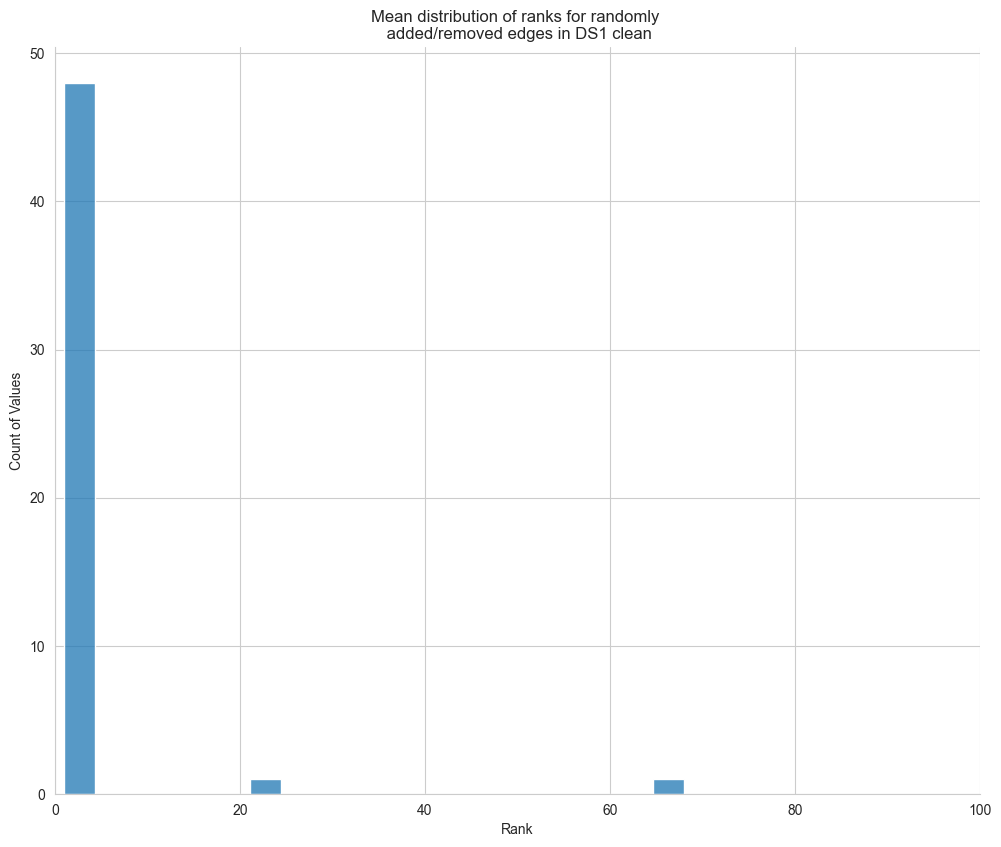

<Figure size 1000x600 with 0 Axes>

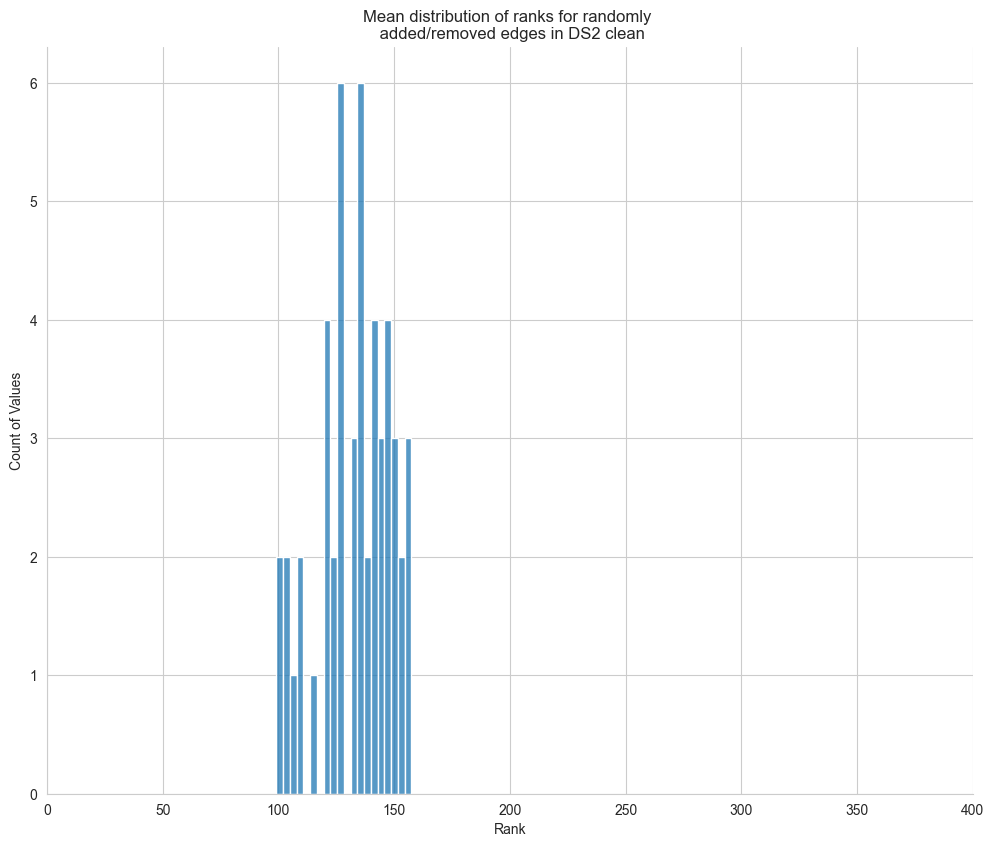

<Figure size 1000x600 with 0 Axes>

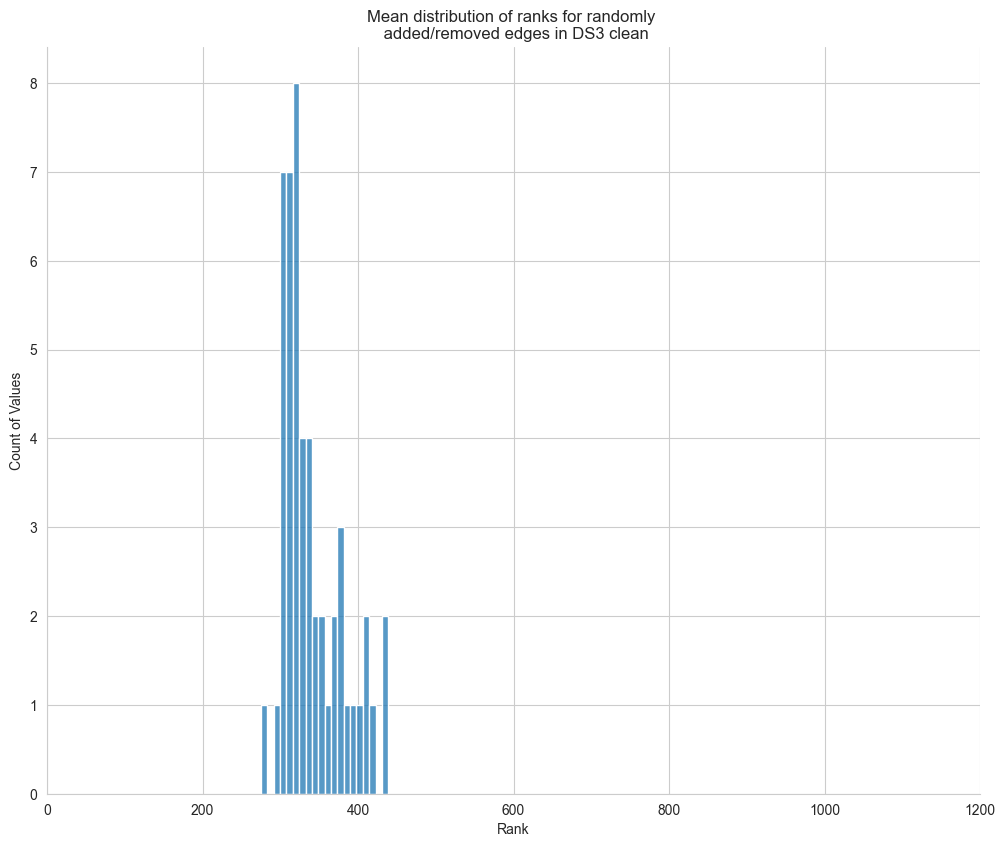

In [8]:
for id in range(1, 4):
    if id == 1:
        lim = 100
    elif id == 2:
        lim = 400
    elif id == 3:
        lim = 1200
    df = pd.read_csv(f'./experiments/mean_diffs/DS{id}/DS{id}_chosen_pairs.csv', header=0, names=['Regulator', 'Target', 'Rank', 'Target Mean', 'Overall Mean', 'Added Edge', 'Iteration'])
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    new_ranks = df.groupby('Iteration').mean()['Rank'].values
    #print(new_ranks)
    #bins = len(np.unique(new_ranks))
    plot = sns.displot(new_ranks, bins=20, kde=False, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    plot.set(xlim=(0, lim))
    plot.set_axis_labels('Rank', 'Count of Values')
    plt.title(f'Mean distribution of ranks for added in normalized DS{id} clean')

In [99]:
new_expected_value_experiment(dataset_id=1, last_iteration=0, fixed_edge=False, add_edge=False, multiple_edges=False, clean='clean', normalize=True)
new_expected_value_experiment(dataset_id=2, last_iteration=0, fixed_edge=False, add_edge=False, multiple_edges=False, clean='clean', normalize=True)
new_expected_value_experiment(dataset_id=3, last_iteration=0, fixed_edge=False, add_edge=False, multiple_edges=False, clean='clean', normalize=True)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

,Regulator,Target,Rank,Target Mean,Overall Mean,Added Edge,Iteration
0,1.0,61.0,5,-1.755185,0.142411,False,3
1,1.0,54.0,3,-1.828148,0.142411,False,3
2,1.0,11.0,31,-0.717407,0.142411,False,3
3,74.0,76.0,68,-0.377037,0.142411,False,3
4,14.0,80.0,16,-1.205926,0.142411,False,3
...,...,...,...,...,...,...,...
3714,1.0,95.0,31,-0.362593,0.092444,True,50
3715,14.0,80.0,17,-1.239630,0.092444,False,50
3716,44.0,38.0,16,-0.192963,0.092444,True,50
3717,74.0,0.0,64,-0.669630,0.092444,True,50


[41.68421053 42.11111111 37.89473684 32.97368421 21.74666667 23.22666667
 44.77333333 42.78947368 49.75       36.91891892 39.72368421 24.46753247
 25.45454545 23.06578947 46.05479452 43.38157895 25.42465753 24.23287671
 26.81333333 33.67532468 22.82191781 44.25974026 22.8        27.33783784
 36.68918919 22.04       22.72222222 25.53947368 35.97183099 28.15789474
 30.47945205 23.98648649 29.44594595 43.31168831 24.85333333 39.06666667
 26.64864865 41.01388889 32.57534247 24.02702703 24.         27.23684211
 31.09589041 30.68055556 23.56756757 39.7260274  43.24       42.90277778
 42.63013699 39.65333333]


,Regulator,Target,Rank,Target Mean,Overall Mean,Added Edge,Iteration
0,238.0,291.0,28,2.288119,-0.065073,True,2
1,102.0,353.0,78,0.898499,-0.065073,True,2
2,238.0,62.0,114,0.278431,-0.065073,True,2
3,54.0,198.0,6,3.329137,-0.065073,True,2
4,69.0,215.0,35,2.050426,-0.065073,True,2
...,...,...,...,...,...,...,...
16145,115.0,236.0,47,-1.915774,0.007598,False,50
16146,150.0,274.0,393,-4.047623,0.007598,True,50
16147,302.0,23.0,85,0.933167,0.007598,True,50
16148,144.0,136.0,58,1.325501,0.007598,True,50


[ 96.78153846  93.00925926  87.87619048  90.66246057  85.84858044
  93.67073171  82.39116719 101.33641975  85.87106918  89.06707317
  97.19877676  97.8006135   87.68037975  93.36024845  92.17337461
  94.65957447  99.00619195  93.36923077  90.22049689  96.46325879
  92.12538226  92.34036145  93.77358491  95.87537994  93.24842767
  95.53495441  94.21875     95.97553517  91.21495327  91.5875
  94.78816199  91.74213836  94.7037037   85.87345679  98.16109422
 101.44036697  91.20376176 106.59133127  94.17901235 102.2211838
  92.78287462  89.81481481  92.03761755  93.43533123  95.27300613
  97.08307692  98.49693252  94.49226006  92.69565217  97.03625378]


,Regulator,Target,Rank,Target Mean,Overall Mean,Added Edge,Iteration
0,636.0,619.0,226,-1.067457,-0.061864,False,2
1,513.0,530.0,997,-1.257104,-0.061864,True,2
2,110.0,482.0,183,0.967694,-0.061864,True,2
3,359.0,326.0,175,1.091867,-0.061864,True,2
4,684.0,182.0,868,-0.288967,-0.061864,True,2
...,...,...,...,...,...,...,...
38470,1033.0,757.0,194,1.021695,-0.021495,True,50
38471,1133.0,1142.0,214,-1.137556,-0.021495,False,50
38472,636.0,923.0,41,3.185016,-0.021495,True,50
38473,826.0,827.0,75,-2.638056,-0.021495,False,50


[264.33896104 255.87859008 240.74348958 246.41775457 244.19635891
 266.86700767 265.09882965 262.63636364 249.29473684 233.61861075
 251.28828829 244.00780234 253.59114583 269.88       255.74677003
 250.24412533 254.67014342 265.20854922 271.9452412  247.23691099
 266.60512821 255.98036649 254.02230971 262.98326898 239.9496124
 237.34993447 260.54929577 262.60446781 244.51554404 257.43472585
 275.23643411 239.71557272 256.32552083 240.39556136 266.17076326
 243.31694696 264.97389034 262.74571805 267.14583333 247.40572172
 250.0994832  248.09499358 257.96614583 239.03660131 247.8515625
 247.15665796 243.06119792 267.15414508 247.74445893 234.91332471]


<Figure size 1000x600 with 0 Axes>

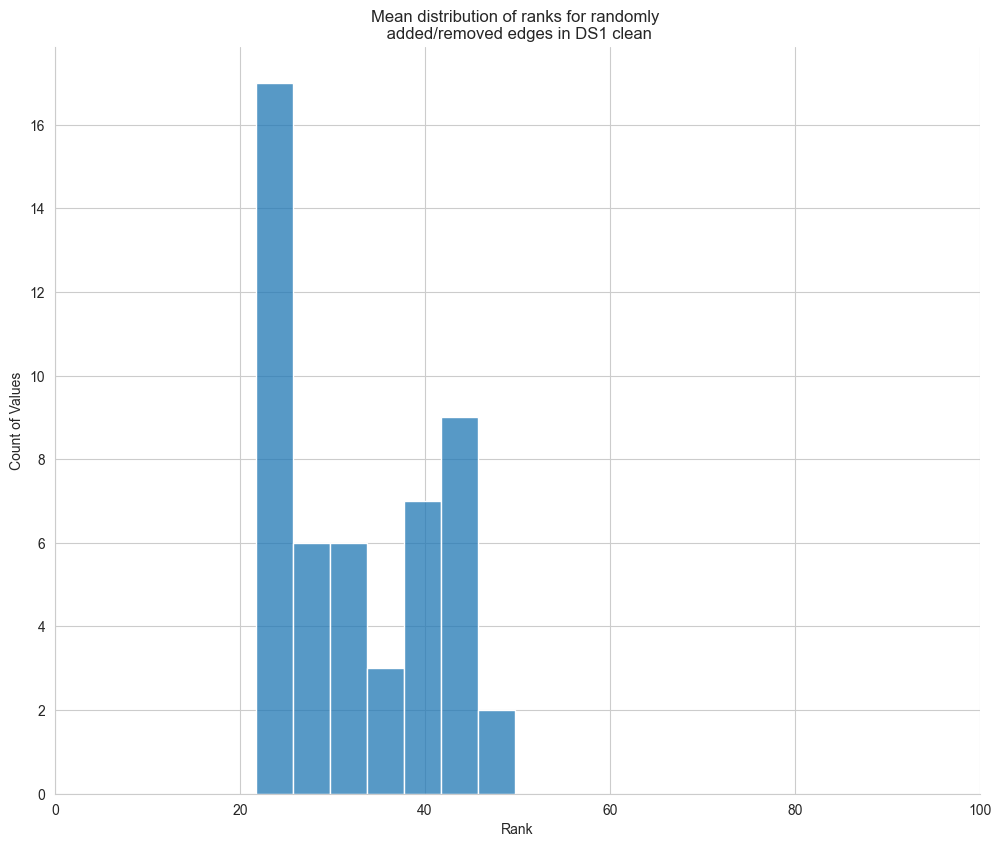

<Figure size 1000x600 with 0 Axes>

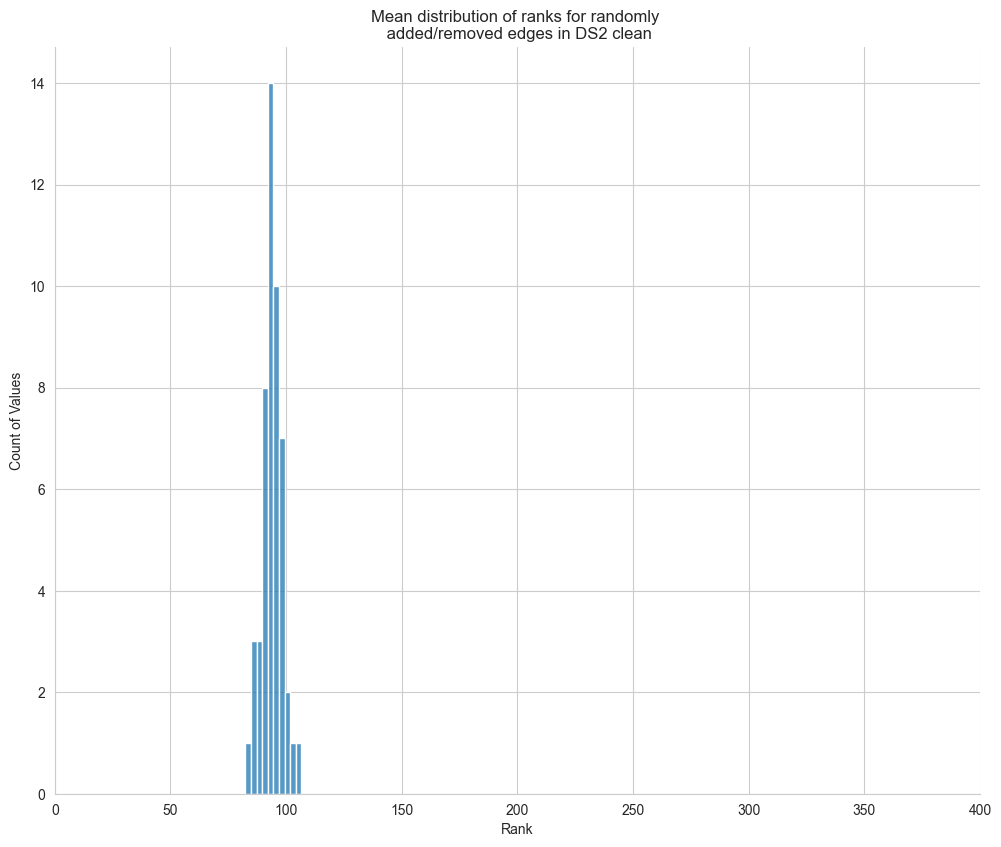

<Figure size 1000x600 with 0 Axes>

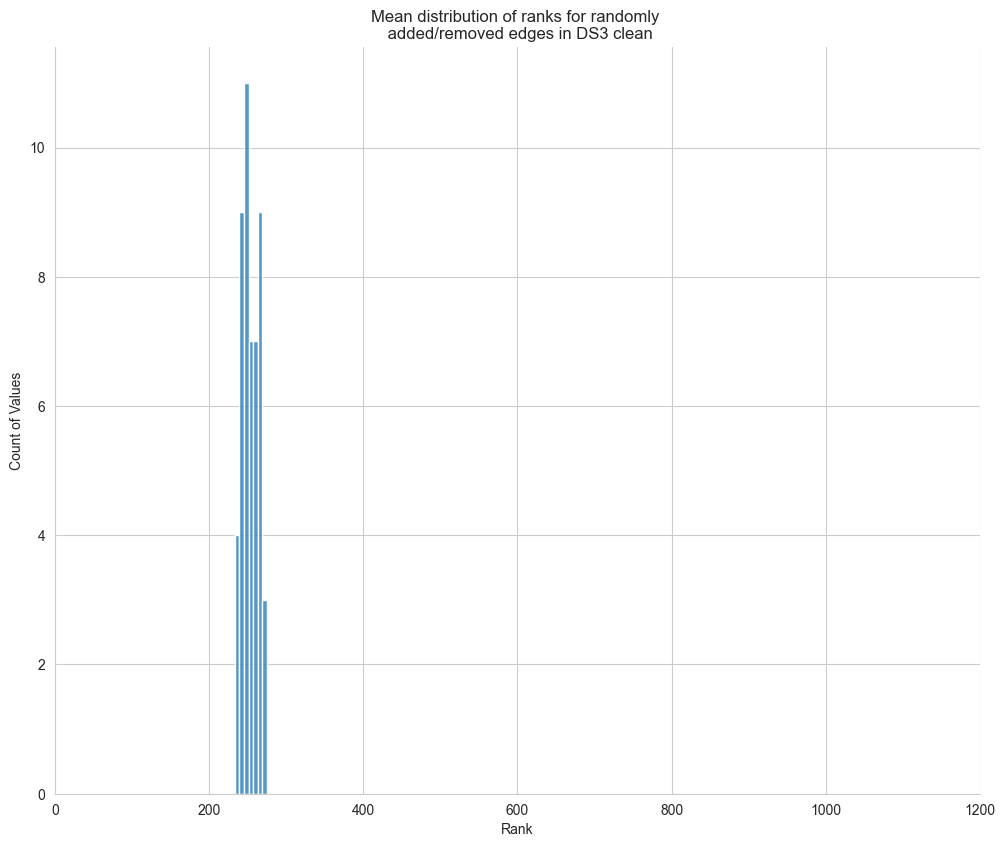

In [103]:
for id in range(1, 4):
    if id == 1:
        lim = 100
    elif id == 2:
        lim = 400
    elif id == 3:
        lim = 1200
    df = pd.read_csv(f'./experiments/mean_diffs/DS{id}/DS{id}_chosen_pairs.csv', header=0, names=['Regulator', 'Target', 'Rank', 'Target Mean', 'Overall Mean', 'Added Edge', 'Iteration'])
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    new_ranks = df.groupby('Iteration').mean()['Rank'].values
    #print(new_ranks)
    #bins = len(np.unique(new_ranks))
    plot = sns.displot(new_ranks, bins=20, kde=False, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    plot.set(xlim=(0, lim))
    plot.set_axis_labels('Rank', 'Count of Values')
    plt.title(f'Mean distribution of ranks for randomly \n removed edges in normalized DS{id} clean')